In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from torchvision.io import read_image

import torchvision
import torchvision.models as models
import torch
import os

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Pad, Compose,CenterCrop, ToPILImage, Normalize, ConvertImageDtype, Resize, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt


In [2]:
class GTSRB(Dataset):
    def __init__(self, annotations_file, img_dir , transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)[["Path","ClassId"]]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        label = self.img_labels.iloc[idx, 1]
        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [81]:
data_loc = 'traffic_data'

data_transforms = {
    'train': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,244)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ConvertImageDtype(torch.float32)
    ]),
    'test': transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ConvertImageDtype(torch.float32)
    ]),
}
img_dir = data_loc
test_csv = data_loc+"/Test.csv"
test_data = GTSRB(img_dir = img_dir, annotations_file = test_csv,
                  transform = data_transforms["test"])

train_csv = data_loc+"/Train.csv"
train_data = GTSRB(img_dir = img_dir, annotations_file = train_csv,
                  transform = data_transforms["train"])

#print(test_dataloader)
train_data_path = data_loc+"/Train"



dataset = {
    "train" : torchvision.datasets.ImageFolder(root = train_data_path, transform =data_transforms["train"]),
    
    #"test" : torchvision.datasets.ImageFolder(root = test_data_path, transform =data_transforms["test"])
}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

dataset_loader ={
    "train" : DataLoader(train_data, batch_size=64, shuffle=True),
    
    "test" : DataLoader(test_data, batch_size=64, shuffle=True)
}
#print(len(dataset_loader["test"].dataset), len(dataset_loader["train"].dataset))

{'train': 39209, 'test': 12630}
Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


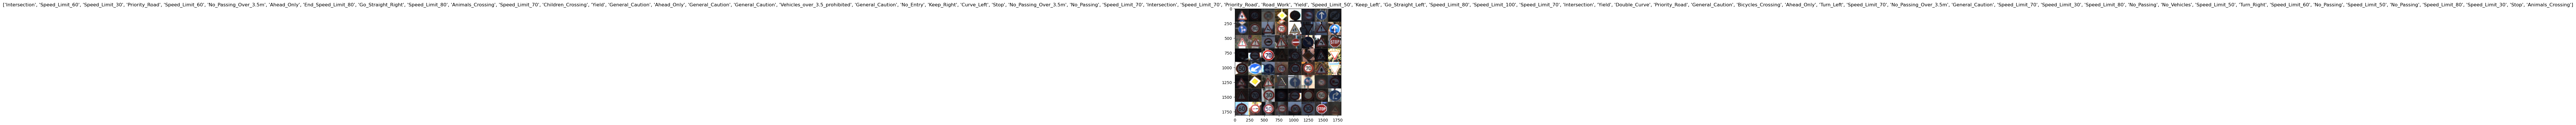

In [83]:
class_ids = ["Speed_Limit_20","Speed_Limit_30","Speed_Limit_50","Speed_Limit_60", "Speed_Limit_70", "Speed_Limit_80",
            "End_Speed_Limit_80","Speed_Limit_100","Speed_Limit_120","No_Passing","No_Passing_Over_3.5m","Intersection",
            "Priority_Road","Yield","Stop","No_Vehicles","Vehicles_over_3.5_prohibited","No_Entry","General_Caution",
            "Curve_Left","Curve_Right","Double_Curve","Bumpy_Road", "Slippery_road","Narrowroad_Right","Road_Work","Traffic_Lights",
            "Pedestrains","Children_Crossing","Bicycles_Crossing","Beware_Ice_and_Snow","Animals_Crossing","End_of_all_speed_limits",
            "Turn_Right","Turn_Left","Ahead_Only","Go_Straight_Right","Go_Straight_Left","Keep_Right","Keep_Left","Roundabout_Mandatory",
            "End_no_passing","End_no_passing_over_3.5"]

class_names={int(x) : class_ids[int(x)] for x in os.listdir(train_data_path)}

#print(class_names)

dataset_sizes = {'train' : len(dataset_loader["train"].dataset), 'test': len(dataset_loader["test"].dataset)}
print(dataset_sizes)

train_features, train_labels = next(iter(dataset_loader["train"]))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataset_loader['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x.item()] for x in classes])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import time
import os
import copy

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataset_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(best_model_wts, "Models/best_model")
    return model

In [10]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataset_loader['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j].item()]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


In [7]:
model_ft = models.wide_resnet50_2(pretrained=True)
#wideresnet.eval()
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 43)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\teaki\anaconda3\envs\Pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 43)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [10]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 1.7270 Acc: 0.3603
test Loss: 6.0101 Acc: 2.4178

Epoch 1/24
----------
train Loss: 1.0679 Acc: 0.5161
test Loss: 4.5770 Acc: 2.7528

Epoch 2/24
----------
train Loss: 0.8662 Acc: 0.5633
test Loss: 3.8699 Acc: 2.9151

Epoch 3/24
----------
train Loss: 0.7554 Acc: 0.5900
test Loss: 3.3956 Acc: 3.0585

Epoch 4/24
----------
train Loss: 0.6817 Acc: 0.6080
test Loss: 3.0681 Acc: 3.1443

Epoch 5/24
----------
train Loss: 0.6301 Acc: 0.6203
test Loss: 2.8983 Acc: 3.1804

Epoch 6/24
----------
train Loss: 0.5892 Acc: 0.6300
test Loss: 2.6991 Acc: 3.2207

Epoch 7/24
----------
train Loss: 0.5621 Acc: 0.6378
test Loss: 2.6355 Acc: 3.2415

Epoch 8/24
----------
train Loss: 0.5587 Acc: 0.6399
test Loss: 2.6624 Acc: 3.2379

Epoch 9/24
----------
train Loss: 0.5581 Acc: 0.6385
test Loss: 2.6172 Acc: 3.2524

Epoch 10/24
----------
train Loss: 0.5547 Acc: 0.6393
test Loss: 2.5962 Acc: 3.2533

Epoch 11/24
----------
train Loss: 0.5513 Acc: 0.6394
test Loss: 2.5966 Acc

KeyboardInterrupt: 

In [8]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------


OutOfMemoryError: CUDA out of memory. Tried to allocate 50.00 MiB (GPU 0; 6.00 GiB total capacity; 5.19 GiB already allocated; 0 bytes free; 5.28 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

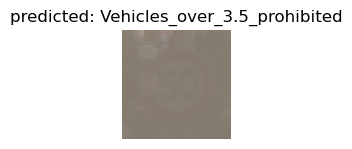

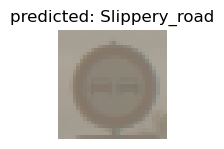

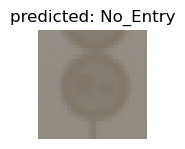

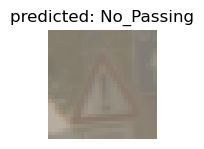

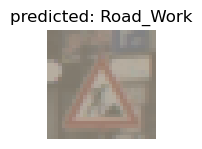

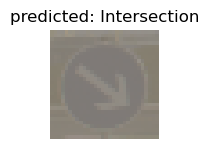

In [11]:
visualize_model(model_ft)